# Applied Machine Learning Systems (MLS-1) - ELEC0134

# Final Assignment - Classification of Tumours

## Task A - Binary Classification using Support Vector Machines (SVM)

## Completed by Student Number - 18014580

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is a Jupyter Notebook submitted as part of the final assignment for the Applied Machine Learning Systems (MLS-1) coursework which involves tumor classification and identification.

This particular notebook tests the SVM method using the SVC model from the sklearn library on Task A to find the accuracy of using support vector machines classification for this particular task.

### Importing different packages

Initially, we must import the different packages needed for this task. The packages required to implement suport vector machines for this binary task can be found in pandas, sklearn (scikit-learn), skimage (scikit-image), and numpy. Please ensure these are installed in your virtualenv before running this code.

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from skimage import io
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.feature import hog

# import tensorflow as tf
#from keras.preprocessing import image
import matplotlib.pyplot as plt

import os
from os import listdir

import seaborn as sns

from datetime import datetime

print("All imports carried out successfully")

All imports carried out successfully


### Loading the data from the data sets

In this cell we are using read_csv to load the labels for each image into a dataframe. We then display the dataframe to ensure the data from the .csv file was loaded correctly.

Comment out the Google Drive path and uncomment the Jupyter path when running on Notebook (not Colab) as the dataset and test files will be in the same directory as the .ipynb files when downloaded from the GitHub repo. 

Ensure the folders "set" and "dataset" are in the same folder as the Notebook before running it.


In [4]:
#Loading the CSV file 'label' containing the different labels for each MRI Scan

#Used this path while running on Google Colab for accelerated GPU
label_path_GDrive = '/content/drive/MyDrive/Colab Notebooks/dataset/label.csv'

#Used this path when running regularly on Jupyter Notebook from repository
label_path_Jupyter = '.dataset/label.csv'

tumour_labels = pd.read_csv(label_path_GDrive)
#tumour_labels = pd.read_csv(label_path_Jupyter)

print(tumour_labels.shape) #Outputs array with the shape of the dataframe to ensure all images, filenames and labels loaded

(3000, 2)


In [5]:
tumour_labels #Displaying data frame to visually ensure data loaded correctly

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor
...,...,...
2995,IMAGE_2995.jpg,no_tumor
2996,IMAGE_2996.jpg,meningioma_tumor
2997,IMAGE_2997.jpg,glioma_tumor
2998,IMAGE_2998.jpg,glioma_tumor


### Printing out dataset to ensure labels changed accordingly

This is a binary classification task, so in the cells below, we modify the data frame by locating all the images whose label is not "no_tumor" and setting them to tumor rather than having them as the types of tumor.

In [6]:
#change anything in the label column that is not equal to "no_tumor" to "tumor" rather than the type of tumor
tumour_labels.loc[tumour_labels['label']!= 'no_tumor', 'label'] = 'tumor' 

In [7]:
tumour_labels #Displaying data frame to visually ensure labels changed as specified in cell above

,file_name,label
0,IMAGE_0000.jpg,tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,tumor
3,IMAGE_0003.jpg,tumor
4,IMAGE_0004.jpg,tumor
...,...,...
2995,IMAGE_2995.jpg,no_tumor
2996,IMAGE_2996.jpg,tumor
2997,IMAGE_2997.jpg,tumor
2998,IMAGE_2998.jpg,tumor


### Adding numeric representation to the data frame¶

In the cells below, we add another column to the data frame and assign a numeric value label to each label. Since our problem is binary, the numeric label can only be 1 or 0.

If the label indicates "tumor" it is assigned a numeric label 1, and if the label does not indicate a tumour "no_tumor" it is assigned the numeric label 0. It also increases adaptability or convenience of the code if deep-learning models were to be used to have numeric label rather than a text label.

In [8]:
classes = ['no_tumor', 'tumor']
for CLASS in classes:
    tumour_labels.loc[tumour_labels['label'] == CLASS, 'numeric label'] = classes.index(CLASS)

In [9]:
tumour_labels #Displaying dataframe to ensure new column created and values are being assigned properly

,file_name,label,numeric label
0,IMAGE_0000.jpg,tumor,1.0
1,IMAGE_0001.jpg,no_tumor,0.0
2,IMAGE_0002.jpg,tumor,1.0
3,IMAGE_0003.jpg,tumor,1.0
4,IMAGE_0004.jpg,tumor,1.0
...,...,...,...
2995,IMAGE_2995.jpg,no_tumor,0.0
2996,IMAGE_2996.jpg,tumor,1.0
2997,IMAGE_2997.jpg,tumor,1.0
2998,IMAGE_2998.jpg,tumor,1.0


### Choosing mode and loading the images

In the cell below, we load the image files using the imread functions from the scikit-image package. We convert the images to grayscale as a form of preprocessing. 

The images (whether grayscale or not) numpy arrays before appending them to a list. This list of arrays is then converted to a numpy array of arrays to allow us to print the shape to verify all the images have been loaded.

This cell also uses datetime.now() to output the time elapsed to load the image set. This was used to compare efficiency of different imread functions from different packages including skimage, cv2 etc. In the end, skimage was chosen as it produced slightly favourable results.

The time elapsed to load the images was:  0:00:57.899138
(3000, 512, 512)


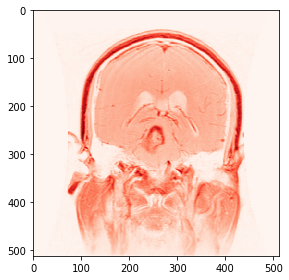

In [10]:
#Uncomment to verify contents of the directory loaded

""" directory contains the path of the image folder on the computer for running on Jupyter notebook when all files are in the same directory  
    drive_directory contains the path of the image folder on Google Drive for when Colab was being used for higher computational power.

    NOTE: As the order of the images was reshuffled when being uploaded to Google Drive due to internet speeds, we must use sorted() at the
    beginning of the for-loop when using dirpath otherwise the images will not be loaded in the order matching their corresponding labels. 
    Explicity this means when using Colab the for loop should read "for file in sorted(listdir(drive_directory))" instead of
    "for file in listdir(directory)".
    
    Change the name of the path in the for loop accordingly."""

directory = './dataset/image'
drive_directory = '/content/drive/MyDrive/Colab Notebooks/dataset/image'
#print(listdir(directory))
#print(listdir(drive_directory))

#Code used to test timing

start = datetime.now() #Stores the time at which loading starts

images = [] #An empty list is created

"""The for loop below uses listdir to iterate through names of all the files in the directory and uses to
populate the list images. The image is converted into grayscale using rgb2gray as this grayscale images only
have one channel which will increase efficiency of the code as we and decrease complexity whilst still yielding 
similar results. Testing carried out by me showed that we should stick to grayscale.

The user can optionally comment out lines 23-25 and uncomment lines 27 and 28 to leave the image in RGB rather
than convert it to grayscale"""

for file in sorted(listdir(drive_directory)):
    img = io.imread(drive_directory + '/' + file)
    gray_img = rgb2gray(img)
    gray_img = np.array(gray_img)
    images.append(gray_img)
    
    #img = np.array(img)
    #images.append(img) 
        
#Marking the end of the code loading the images 
end = datetime.now()
elapsed = end - start #Calculating time elapsed while comparing different packages used to load images
print('The time elapsed to load the images was: ', + elapsed) 

"""Below we chose a random image from the dataset (image[45]) to show below so the user can visually verify
the type of image. We apply a red colormap in the imshow function so that if the image is shown with red tones
the user knows it was converted to grayscale and if it shows as a regular black and white MRI then it was not."""

io.imshow(np.array(images[45]), cmap='Reds') #red colormap only appears if grayscale image
print(np.array(images).shape) #Converting list images to a numpy array before outputting shape to verify 

### Feature Extraction using HOG - Histogram of Oriented Gradients

In the previous cell, we preprocess the image by potentially changing it a grayscale image. To further this preprocessing, we use a Historgram of Oriented Gradient. This is done using the hog function from scikit-image.

An HOG is needed as this extracts features from the image that a machine learning algorithm can better understand to increase the accuracy of training and any future predictions.

In [11]:
features_hog = []
images_hog = []

for index in range(len(images)):
    hog_feature, hog_image = hog(images[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    features_hog.append(hog_feature)
    images_hog.append(hog_image)


In [12]:
print(np.array(features_hog).shape)
print(np.array(images_hog).shape)

(3000, 72900)
(3000, 512, 512)


In [ ]:
i0.imshow(np.array(images[502]))

In [ ]:
i0.imshow(np.array(images_hog[502]))

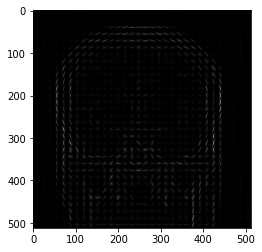

In [ ]:
features_hog, image_hog = hog(images[26], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))

plt.imshow(image_hog, cmap = 'gray')

In [138]:
general_features = []

for index in range(len(images)):
    flattened = images[index].flatten()
    hogfeat = hog_feature[index]
    feats = np.hstack((flattened, hogfeat))
    general_features.append(flattened)

general_feature_matrix = np.array(general_features)


In [152]:
feature_matrix = np.array(features_hog)
print(feature_matrix.shape)
print(general_feature_matrix.shape)

(3000, 72900)
(200, 262144)


In [140]:
scaler = StandardScaler()
scaled = scaler.fit_transform(feature_matrix)

In [141]:
scaler = StandardScaler()
scaled = scaler.fit_transform(general_feature_matrix)

In [154]:
pca = PCA()
tumours_pca_features = pca.fit_transform(feature_matrix)

In [148]:
pca = PCA()
gen_tumours_pca_features = pca.fit_transform(general_feature_matrix)

In [155]:
print(tumours_pca_features.shape)
print(gen_tumours_pca_features.shape)

(3000, 3000)
(200, 200)


### Splitting the data into training and testing data

In the cells below, we use train_test_split from the model_selection part of the sklearn package. This splits the data into training and testing data before we train the model. The testing data is left unseen so we can test our trained model using it.

In [156]:
#X = np.array(images) #Set X to contain the array of images
X = feature_matrix;
#X = feature_matrix
Y = tumour_labels['numeric label'] #Set Y to contain the corresponding numeric labels of each image

xTrain, xTest, yTrain, yTest = train_test_split(X,Y, random_state = 0) #Set random_state to 0 for reproducibility

print(xTrain.shape) #Printing the shape of xTrain to veryify data was split correctly
print(xTest.shape) #Printing the shape of xTest to verify  data was split correctly
train_size = xTrain.shape[0]
test_size = xTest.shape[0]

(2250, 72900)
(750, 72900)


### Reshaping xTrain and xTest for use in ML models and verifying the reshape

These cells reshape xTrain and xTest to 2-dimensional arrays and verifies they have been correctly reshaped depending on whether or not they were converted to grayscale.

In [ ]:
#Reshaping xTrain and xTest each to 2-dimensional arrays to allow them to be input into models such as Logistic Reg and SVMs

#If statement to control reshaping of xTrain and xTest dependent if using RGB or Grayscale
#If RGB then .shape arrays will have 4 elements, so we reshape using [1], [2] and [3] from xTrain.shape
#Otherwise, if Grayscale .shape arrays will only have 3 elements so we reshape using only [1] and [2] as there is no [3]

if len(xTrain.shape) == 4:
    xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1]*xTrain.shape[2]*xTrain.shape[3])
    xTest = xTest.reshape(xTest.shape[0], xTest.shape[1]*xTest.shape[2]*xTest.shape[3])
elif len(xTrain.shape) == 3:
    xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1]*xTrain.shape[2])
    xTest = xTest.reshape(xTest.shape[0], xTest.shape[1]*xTest.shape[2])    

In [157]:
xTrain.shape #Visually verifying xTrain has been reshaped

(2250, 72900)

In [158]:
xTest.shape #Visually verifying xTest has been reshaped

(750, 72900)

In [ ]:
if color_mode.lower().startswith("n"):
    if xTrain.shape[0] == train_size and xTrain.shape[1] == 512*512*3:
        print('xTrain reshaped correctly')
    else: print('xTrain reshaped incorrectly')
    if xTest.shape[0] == test_size and xTest.shape[1] == 512*512*3:
        print('xTest reshaped correctly')
    else: print('xTest reshaped incorrectly')
elif color_mode.lower().startswith("y"):
    if xTrain.shape[0] == train_size and xTrain.shape[1] == 512*512:
        print('xTrain reshaped correctly')
    else: print('xTrain reshaped incorrectly')
    if xTest.shape[0] == test_size and xTest.shape[1] == 512*512:
        print('xTest reshaped correctly')
    else: print('xTest reshaped incorrectly')

xTrain reshaped correctly
xTest reshaped correctly


### Training the models

In [159]:
start_model1 = datetime.now()
model1_svmlinear = SVC(kernel='linear')
model1_svmlinear.fit(xTrain, yTrain)
end_model1 = datetime.now()
time_model1 = end_model1 - start_model1
print('The training time for Model 1 (SVM with Kernel = Linear) is: ', time_model1)

The training time for Model 1 (SVM with Kernel = Linear) is:  0:00:28.094329


In [160]:
start_model2 = datetime.now()
model2_svmpoly = SVC(kernel = 'poly')
model2_svmpoly.fit(xTrain, yTrain)
end_model2 = datetime.now()
time_model2 = end_model2 - start_model2
print('The training time for Model 2 (SVM with Kernel = Poly) is: ', time_model2)

The training time for Model 2 (SVM with Kernel = Poly) is:  0:00:33.886064


In [161]:
start_model3 = datetime.now()
model3_svmrbf = SVC(kernel = 'rbf')
model3_svmrbf.fit(xTrain, yTrain)
end_model3 = datetime.now()
time_model3 = end_model3 - start_model3
print('The training time for Model 1 (SVM with Kernel = Linear) is: ', time_model3)

The training time for Model 1 (SVM with Kernel = Linear) is:  0:00:37.088126


### Model 1 Prediction + Classification Report + Confusion Matrix

In [166]:
y_Pred_model1 = model1_svmlinear.predict(xTest)

In [167]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model1)))
print(classification_report(yTest,y_Pred_model1))#text report showing the main classification metrics

Accuracy on test set: 0.9533333333333334
              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84       123
         1.0       0.96      0.99      0.97       627

    accuracy                           0.95       750
   macro avg       0.94      0.88      0.91       750
weighted avg       0.95      0.95      0.95       750



In [168]:
acc_model1 = model1_svmlinear.score(xTest, yTest)

In [169]:
conf_olddata_model1 = confusion_matrix(yTest, y_Pred_model1)

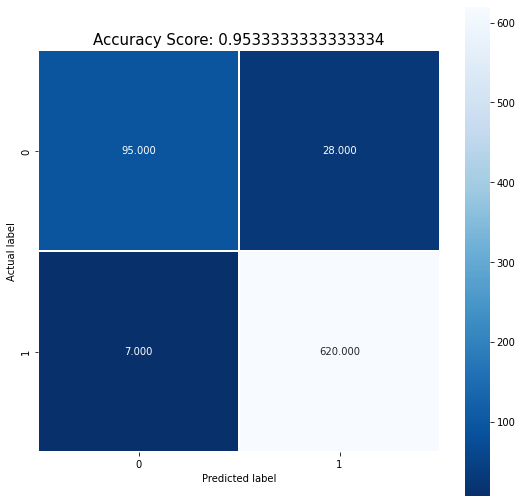

In [170]:
plt.figure(figsize=(9,9))
sns.heatmap(conf_olddata_model1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model1)
plt.title(all_sample_title, size = 15);

### Model 2 Prediction + Classification Report + Confusion Matrix

In [171]:
y_Pred_model2 = model2_svmpoly.predict(xTest)

In [172]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model2)))
print(classification_report(yTest,y_Pred_model2))#text report showing the main classification metrics

Accuracy on test set: 0.9533333333333334
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       123
         1.0       0.96      0.99      0.97       627

    accuracy                           0.95       750
   macro avg       0.95      0.88      0.91       750
weighted avg       0.95      0.95      0.95       750



In [173]:
acc_model2 = model2_svmpoly.score(xTest, yTest)

In [174]:
conf_olddata_model2 = confusion_matrix(yTest, y_Pred_model2)

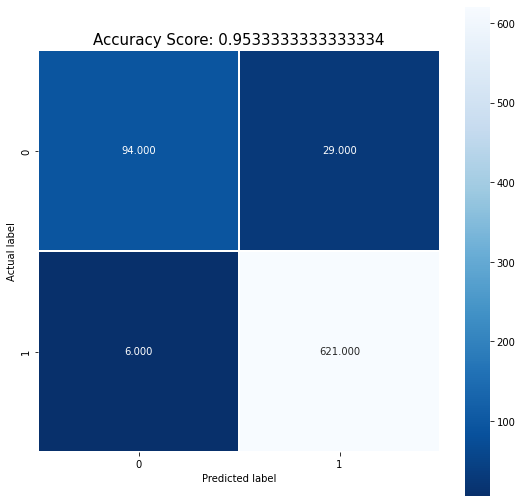

In [175]:
plt.figure(figsize=(9,9))
sns.heatmap(conf_olddata_model2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model2)
plt.title(all_sample_title, size = 15);

### Model 3 Prediction + Classification Report + Confusion Matrix

In [176]:
y_Pred_model3 = model3_svmrbf.predict(xTest)

In [177]:
print('Accuracy on test set: '+str(accuracy_score(yTest,y_Pred_model3)))
print(classification_report(yTest,y_Pred_model3))#text report showing the main classification metrics

Accuracy on test set: 0.94
              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79       123
         1.0       0.94      0.99      0.96       627

    accuracy                           0.94       750
   macro avg       0.93      0.84      0.88       750
weighted avg       0.94      0.94      0.94       750



In [178]:
acc_model3 = model3_svmrbf.score(xTest, yTest)

In [179]:
conf_olddata_model3 = confusion_matrix(yTest, y_Pred_model3)

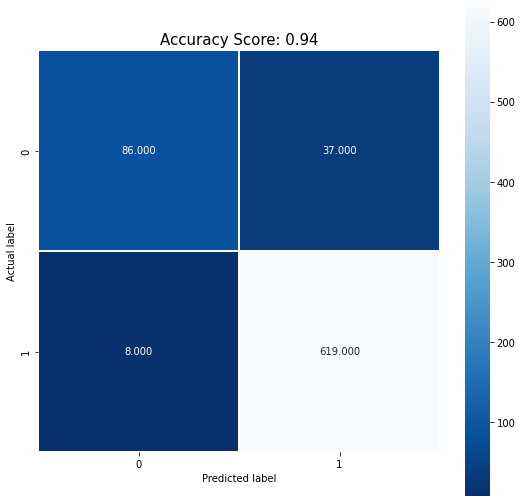

In [180]:
plt.figure(figsize=(9,9))
sns.heatmap(conf_olddata_model3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_model3)
plt.title(all_sample_title, size = 15);

In [1]:
param_grid = param_grid = {'C': [0.1, 0.5, 1, 10, 100], 

              'gamma': [1, 0.1, 0.01, 0.0001],

              'kernel': ['linear', 'rbf', 'poly']} 
 

gridSVM = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
gridSVM.fit(xTrain, yTrain)

NameError: ignored

### Testing and reporting new accuracy score using updated test set 

In the following cells we use similar methods to the ones we had above to load the images from the new test set uploaded, 

In [38]:
new_tumour_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test/label.csv')
# new_tumour_labels = pd.read_csv('./test/label.csv')
print(new_tumour_labels.shape) #Outputs array with the shape of the dataframe to ensure all images, filenames and labels loaded

(200, 2)


In [39]:
new_tumour_labels

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,meningioma_tumor
2,IMAGE_0002.jpg,glioma_tumor
3,IMAGE_0003.jpg,pituitary_tumor
4,IMAGE_0004.jpg,glioma_tumor
...,...,...
195,IMAGE_0195.jpg,pituitary_tumor
196,IMAGE_0196.jpg,no_tumor
197,IMAGE_0197.jpg,meningioma_tumor
198,IMAGE_0198.jpg,no_tumor


In [40]:
#change anything in the label column that is not equal to "no_tumor" to "tumor" rather than the type of tumor
new_tumour_labels.loc[new_tumour_labels['label']!= 'no_tumor', 'label'] = 'tumor' 

In [41]:
new_tumour_labels

,file_name,label
0,IMAGE_0000.jpg,tumor
1,IMAGE_0001.jpg,tumor
2,IMAGE_0002.jpg,tumor
3,IMAGE_0003.jpg,tumor
4,IMAGE_0004.jpg,tumor
...,...,...
195,IMAGE_0195.jpg,tumor
196,IMAGE_0196.jpg,no_tumor
197,IMAGE_0197.jpg,tumor
198,IMAGE_0198.jpg,no_tumor


In [42]:
for CLASS in classes:
    new_tumour_labels.loc[new_tumour_labels['label'] == CLASS, 'numeric label'] = classes.index(CLASS)

In [43]:
new_tumour_labels

,file_name,label,numeric label
0,IMAGE_0000.jpg,tumor,1.0
1,IMAGE_0001.jpg,tumor,1.0
2,IMAGE_0002.jpg,tumor,1.0
3,IMAGE_0003.jpg,tumor,1.0
4,IMAGE_0004.jpg,tumor,1.0
...,...,...,...
195,IMAGE_0195.jpg,tumor,1.0
196,IMAGE_0196.jpg,no_tumor,0.0
197,IMAGE_0197.jpg,tumor,1.0
198,IMAGE_0198.jpg,no_tumor,0.0


The time elapsed to load the images was:  0:00:01.524406
(200, 512, 512)


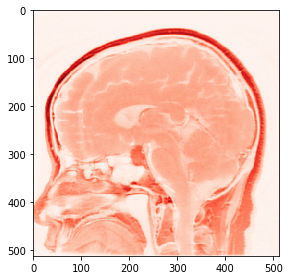

In [45]:
#Uncomment to verify contents of the directory loaded

#Defines the directory name and stores it in dirname
dirpath = '/content/drive/MyDrive/Colab Notebooks/test/image'
dirname = './dataset/image'
#print(listdir(dirname))

#Code used to test timing

start = datetime.now() #Stores the time at which loading starts

validation_images = [] #An empty list is created

"""The for loop below uses listdir to iterate through names of all the files in the directory and uses to
populate the list images. The image is converted into grayscale using rgb2gray as this grayscale images only
have one channel which will increase efficiency of the code as we and decrease complexity whilst still yielding 
similar results. Testing carried out by me showed that we should stick to grayscale.

The user can optionally comment out lines 23-25 and uncomment lines 27 and 28 to leave the image in RGB rather
than convert it to grayscale"""

for file in sorted(listdir(dirpath)):
    img = io.imread(dirpath + '/' + file)
    gray_img = rgb2gray(img)
    gray_img = np.array(gray_img)
    validation_images.append(gray_img)
    
    #img = np.array(img)
    #images.append(img) 
        
#Marking the end of the code loading the images 
end = datetime.now()
elapsed = end - start #Calculating time elapsed while comparing different packages used to load images
print('The time elapsed to load the images was: ', + elapsed) 

"""Below we chose a random image from the dataset (image[45]) to show below so the user can visually verify
the type of image. We apply a red colormap in the imshow function so that if the image is shown with red tones
the user knows it was converted to grayscale and if it shows as a regular black and white MRI then it was not."""

io.imshow(np.array(validation_images[45]), cmap='Reds') #red colormap only appears if grayscale image
print(np.array(validation_images).shape) #Converting list images to a numpy array before outputting shape to verify 

In [46]:
validation_features_hog = []
validation_images_hog = []

for index in range(len(validation_images)):
    hog_feature_val, hog_image_val = hog(validation_images[index], visualize = True, block_norm = 'L2-Hys', pixels_per_cell=(16,16))
    validation_features_hog.append(hog_feature_val)
    validation_images_hog.append(hog_image_val)


In [47]:
print(np.array(validation_features_hog).shape)
print(np.array(validation_images_hog).shape)

(200, 72900)
(200, 512, 512)


In [48]:
validation_feature_matrix = np.array(validation_features_hog)
print(validation_feature_matrix.shape)

(200, 72900)


In [49]:
scaler = StandardScaler()
scaled = scaler.fit_transform(validation_feature_matrix)

In [119]:
pca = PCA()
validation_tumours_pca_features = pca.fit_transform(validation_feature_matrix)

In [120]:
print(validation_tumours_pca_features.shape)

(200, 200)


In [121]:
# x_val = validation_feature_matrix
x_val = validation_tumours_pca_features
y_val = new_tumour_labels['numeric label']
print(x_val.shape)

x_val_size = x_val.shape[0]

(200, 200)


In [ ]:
if len(x_val.shape) == 4:
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3])
elif len(x_val.shape) == 3:
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2]) 

In [122]:
x_val.shape

(200, 200)

In [ ]:
if color_mode.lower().startswith("n"):
    if x_val.shape[0] == x_val_size and x_val.shape[1] == 512*512*3:
        print('Array reshaped correctly')
    else: print('Array reshaped incorrectly')
elif color_mode.lower().startswith("y"):
    if x_val.shape[0] == x_val_size and x_val.shape[1] == 512*512:
        print('Array reshaped correctly')
    else: print('Array reshaped incorrectly')

Array reshaped correctly


## MODEL 1

In [123]:
y_val_Pred_model1 = model1_svmlinear.predict(x_val)

In [124]:
print('Accuracy on new validation set: '+str(accuracy_score(y_val,y_val_Pred_model1)))
print(classification_report(y_val,y_val_Pred_model1)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.655
              precision    recall  f1-score   support

         0.0       0.15      0.19      0.17        37
         1.0       0.81      0.76      0.78       163

    accuracy                           0.66       200
   macro avg       0.48      0.47      0.48       200
weighted avg       0.68      0.66      0.67       200



In [125]:
acc_new_model1 = model1_svmlinear.score(x_val, y_val)

In [126]:
conf_newdata_model1 = confusion_matrix(y_val, y_val_Pred_model1)

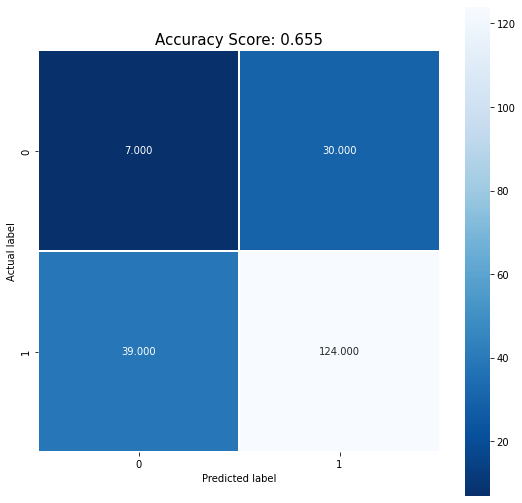

In [127]:
plt.figure(figsize=(9,9))
sns.heatmap(conf_newdata_model1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model1)
plt.title(all_sample_title, size = 15);

## MODEL 2

In [128]:
y_val_Pred_model2 = model2_svmpoly.predict(x_val)

In [129]:
print('Accuracy on new validation set: '+str(accuracy_score(y_val,y_val_Pred_model2)))
print(classification_report(y_val,y_val_Pred_model2)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.81
              precision    recall  f1-score   support

         0.0       0.40      0.05      0.10        37
         1.0       0.82      0.98      0.89       163

    accuracy                           0.81       200
   macro avg       0.61      0.52      0.49       200
weighted avg       0.74      0.81      0.75       200



In [130]:
acc_new_model2 = model2_svmpoly.score(x_val, y_val)

In [131]:
conf_newdata_model2 = confusion_matrix(y_val, y_val_Pred_model2)

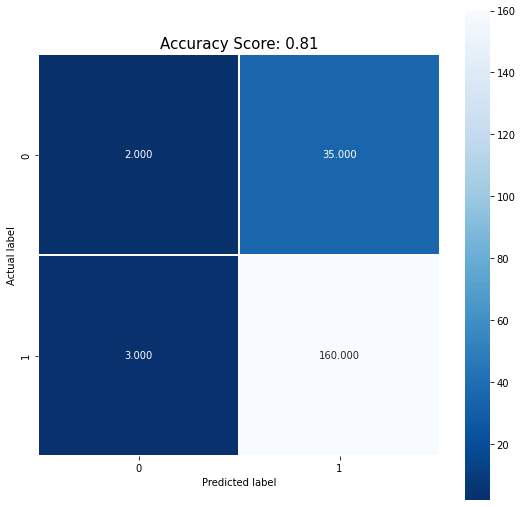

In [132]:
plt.figure(figsize=(9,9))
sns.heatmap(conf_newdata_model2, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model2)
plt.title(all_sample_title, size = 15);

## MODEL 3

In [133]:
y_val_Pred_model3 = model3_svmrbf.predict(x_val)

In [134]:
print('Accuracy on new validation set: '+str(accuracy_score(y_val,y_val_Pred_model3)))
print(classification_report(y_val,y_val_Pred_model3)) #A text report displaying the main classification metrics

Accuracy on new validation set: 0.8
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        37
         1.0       0.81      0.98      0.89       163

    accuracy                           0.80       200
   macro avg       0.41      0.49      0.44       200
weighted avg       0.66      0.80      0.72       200



In [135]:
acc_new_model3 = model3_svmrbf.score(x_val, y_val)

In [136]:
conf_newdata_model3 = confusion_matrix(y_val, y_val_Pred_model3)

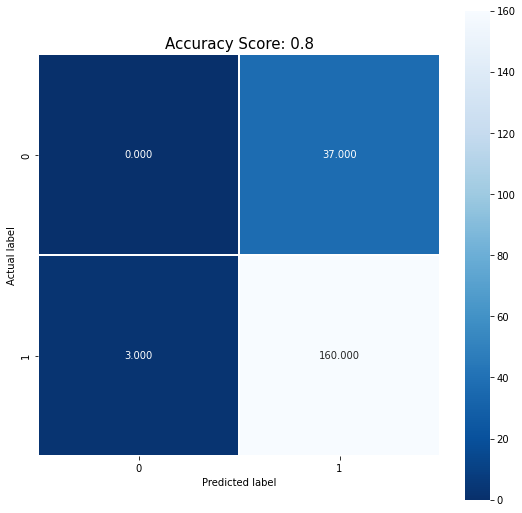

In [137]:
plt.figure(figsize=(9,9))
sns.heatmap(conf_newdata_model3, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_new_model3)
plt.title(all_sample_title, size = 15);